# Generating Emojis with an Autoregression model

In this project I implemented an autoregressive likelihood model for the task of image modeling. It was trained on the apple emojis from the [Full Emoji Image Dataset](https://www.kaggle.com/datasets/subinium/emojiimage-dataset/data).

Firstly I tried to use all the emojis from the dataset, but after some testing I realised that better results were achieved by only training on the "face-like" emojis, There was insufficient training data on the other types of emojis since they differ a lot and that confused the model.

The inspiration for this implementation was the [PixelCNN](https://arxiv.org/pdf/1606.05328.pdf) model.

Firstly, let's import the libraries and initialize the device. (This was done on a mac device, change to "cuda" if applicable)

In [159]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("mps" if torch.backends.mps.is_available() else "cpu")


mps


## 1. Loading the dataset

When I made the decision to drastically narrow down the dataset on only the face-like emojis, I chose the first 95 of them and copied them into a new folder that I named "Apple_Faces".

Here we also initialized the image size and the number of classes (16 classes --> 4 bit colours).

In [189]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

image_size = 32
num_classes = 16

class EmojiDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):

        self.emoji_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return 95 # this was added because I only chose the first 95 emojis from the dataset
        return len(self.emoji_labels)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, str(self.emoji_labels.iloc[idx, 0]) + '.png')

        # Open the image with RGBA mode
        image = Image.open(img_name).convert('RGBA')

        # Create a black background image of the same size
        black_background = Image.new("RGBA", image.size, (0, 0, 0, 255))

        # Composite the original image on top of the black background
        composite_image = Image.alpha_composite(black_background, image)

        # Convert back to RGB, discarding the alpha channel
        image = composite_image.convert('RGB')

        label = self.emoji_labels.iloc[idx, 3]  # Assuming fourth column is the label

        if self.transform:
            image = self.transform(image)

        return image, label

# Path to the folder containing the Apple emoji images
img_dir = './Dataset/image/Apple_Faces'

# Path to the CSV file with emoji labels
csv_file = './Dataset/full_emoji.csv'


def to_int_tensor(image):
    # Convert PIL image to NumPy array and ensure it has integer values
    image_np = np.array(image)
    
    # Convert NumPy array to a PyTorch tensor and ensure it's an integer type
    return torch.tensor(image_np, dtype=torch.int64).permute(2, 0, 1)

def to_scaled_int_tensor(image, num_classes):
    # Convert PIL image to NumPy array and ensure it has integer values
    image_np = np.array(image)

    # Scale the pixel values from [0, 255] to [0, num_classes]
    image_np_scaled = (image_np / 255.0) * num_classes
    image_np_scaled = np.round(image_np_scaled).astype(np.int64)  # Ensure integer values

    # Convert NumPy array to a PyTorch tensor
    return torch.tensor(image_np_scaled, dtype=torch.int64)

# Define any image transformations (e.g., resizing, normalization)
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Resize images if necessary
    transforms.Lambda(to_int_tensor),        # Convert PIL images to tensors
    transforms.Lambda(lambda img: to_scaled_int_tensor(img, num_classes)),  # Convert and scale to discrete values
])

# Create the dataset
emoji_dataset = EmojiDataset(csv_file=csv_file, img_dir=img_dir, transform=transform)

# Example of how to load an image and label
image, label = emoji_dataset[40]
print(f"Image size: {image.size()}")
print(f"Label: {label}")

Image size: torch.Size([3, 32, 32])
Label: face with rolling eyes


/var/folders/db/b4g1bwvj4qd9pwhjmkfm9pxh0000gn/T/ipykernel_36961/1014005030.py:59: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  image_np = np.array(image)


Here is a function that visualises an image from the dataset:

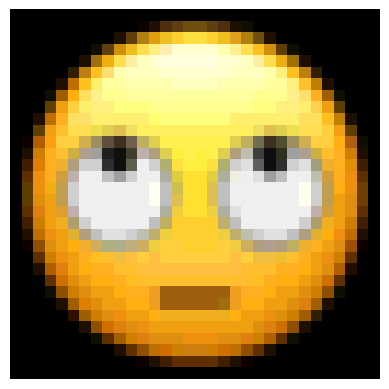

In [190]:
def show_tensor_image(image_tensor):
    image_tensor = image_tensor.permute(1, 2, 0)

    # Convert the tensor to a numpy array (bring channels to last dimension)
    image_np = image_tensor.numpy()
    
    # Clip the values to be between 0 and 1 for proper visualization
    image_np = image_np / num_classes
    
    plt.imshow(image_np)
    plt.axis('off')
    plt.show()

# print(image)
show_tensor_image(image)

## 2. Defining the Auto-Regression Model

To prevent the model from "cheating" (looking at pixels that were not generated yet), we use Masked Convolutions. 

These Masked Convolutions follow a simple rule - Any pixel to the right and the bottom can not influence the value of the result, therefore, they have to be masked and ignored. That is because after the training phase, our model will generate the image from top to bottom, left to right, row by row.

There are two types of masked convolutions we will use:
* A mask --> the mask zeros out the center pixel, this is used only in the first layer to prevent the cheating
* B mask --> the mask doesn't zero out the center pixel, this is used in all subsequent layers since the information about the center pixel has already been lost in the first layer.

This implementation has the initial convolutional layer, three hidden convolutional layers and one more output layer.

All images have three color channels (RGB), so that is something I had to account for, especially in the last layer and it's dimension.

In [162]:
# Define the Masked Convolution Layer
class MaskedConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, mask_type, **kwargs):
        super(MaskedConv2d, self).__init__(in_channels, out_channels, kernel_size, **kwargs)
        # Create the mask
        self.register_buffer('mask', torch.ones(self.weight.size()))
        
        # Define the center pixel of the kernel
        _, _, height, width = self.weight.size()
        yc, xc = height // 2, width // 2

        if mask_type == 'A':  # Type A mask (used in the first layer)
            self.mask[:, :, yc, xc:] = 0  # Zero out the pixels to the right
            self.mask[:, :, yc+1:, :] = 0  # Zero out the pixels below
        elif mask_type == 'B':  # Type B mask (used in deeper layers)
            self.mask[:, :, yc, xc+1:] = 0  # Zero out the pixels to the right
            self.mask[:, :, yc+1:, :] = 0  # Zero out the pixels below

    def forward(self, x):
        # Apply the mask to the weights
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)
    
# Define the PixelCNN model
class PixelCNN(nn.Module):
    def __init__(self, input_dim=3, num_classes=256, hidden_dim=64):
        super(PixelCNN, self).__init__()
        
        # The first layer uses the Type A mask (to prevent cheating on the pixel itself)
        self.conv1 = MaskedConv2d(input_dim, hidden_dim, kernel_size=3, mask_type='A', padding=1)
        
        # Intermediate layers use Type B mask (since pixel can see itself)
        self.conv2 = MaskedConv2d(hidden_dim, hidden_dim, kernel_size=7, mask_type='B', padding=3)
        self.conv3 = MaskedConv2d(hidden_dim, hidden_dim, kernel_size=9, mask_type='B', padding=4)
        self.conv4 = MaskedConv2d(hidden_dim, hidden_dim, kernel_size=7, mask_type='B', padding=3)
        
        # Output layer (predicts the class of each pixel for each RGB channel)
        self.conv_out = nn.Conv2d(hidden_dim, num_classes * 3, kernel_size=1)
    
    def forward(self, x):
        # [ 0, num_classes ] => [ -1, 1 ]
        x = x / ((num_classes-1) * 1.0)

        # Pass through masked convolutions
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        
        # Output layer (no activation here as it will be followed by softmax during loss calculation)
        x = self.conv_out(x)

        # Reshape the output into three parts, one for each color channel (R, G, B)
        r = x[:, 0:num_classes, :, :]   # Red channel
        g = x[:, num_classes:2*num_classes, :, :] # Green channel
        b = x[:, 2*num_classes:3*num_classes, :, :] # Blue channel

        # Stack them back along the second dimension (RGB channels)
        x = torch.stack([r, g, b], dim=1)

        return x.transpose(2, 3).transpose(3, 4)


# Define the model
input_dim = 3  # RGB channels
# num_classes = 16  # Grayscale pixel values (0 to 255)
model = PixelCNN(input_dim=input_dim, num_classes=num_classes).to(device)

# Example input: Batch of grayscale images (batch_size=1, height=16, width=16)
batch_size = 1
dummy_input = torch.randint(0, num_classes, (batch_size, input_dim, image_size, image_size), dtype=torch.float32) / 255.0
print(dummy_input.shape)

# Forward pass
output = model(dummy_input.to(device))

# Output will have shape (batch_size, num_classes, height, width), 
# where num_classes = 256 (for pixel value classification in grayscale)
print(output.shape)  # Example output: torch.Size([1, 3, 256, 16, 16])

torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32, 16])


## Sampling images

Here I wrote a helper function that will randomly choose pixel values using the given probability distributions.

* sample_one_pixel - chooses an element from a given distributions;
* sample_from_pixelcc - performs sample_one_pixel for each pixel in each color channel of the image.

torch.Size([1, 3, 32, 32])


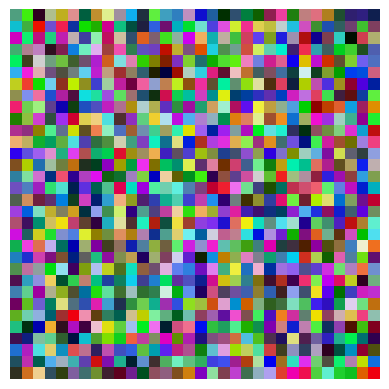

In [163]:
import torch

def sample_one_pixel(output_distribution):
    applied_softmax = F.softmax(output_distribution, dim=0)
    dist = torch.distributions.categorical.Categorical(probs=applied_softmax)
    sampled_pixel = dist.sample()
    return sampled_pixel.item()

def sample_from_pixelcnn(output):
    sampled_image = []
    # print(output.shape)
    batch_size, num_channels, height, width, _ = output.shape

    for b in range(batch_size):
        image = torch.zeros((num_channels, height, width))
        for c in range(num_channels):
            for h in range(height):
                for w in range(width):
                    image[c][h][w] = sample_one_pixel(output[b][c][h][w])
        sampled_image.append(image)

    sampled_image = torch.stack(sampled_image)
    return sampled_image

# Sample from the model (using a random output)
generated_image = sample_from_pixelcnn(output)
print(generated_image.shape)
show_tensor_image(generated_image[0])

## Training the model

Training is extremely efficient due to the utilization of **Teacher Forcing**. Teacher forcing is a method where we do not feed the actual choices of our network as the next input, but we always use the ground truth as input, this parallelises the training process making it faster and also helps the model learn more efficiently in the early stages of training.

I experimented with the hyperparameters of the network a little bit, but there is definitely room for improvement.

As I have already mentiond, the training is extremely efficient. It only took around a minute to train on my laptop.

In [164]:
num_epochs = 250
batch_size = 8
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss = nn.CrossEntropyLoss()

# Create the DataLoader for the dataset
from torch.utils.data import DataLoader
data_loader = DataLoader(emoji_dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(data_loader):
        # this break is just a workournd to avoid the error of the mismatched size of the output and the truth
        if i >= 11: break 

        images = images.to(device)
        
        # Forward pass
        outputs = model(images)

        outputs_flat = outputs.reshape(batch_size * input_dim * image_size * image_size, num_classes)

        # print(images.shape)
        # print(outputs.shape)
        truth_flat = images.view(batch_size * input_dim * image_size * image_size).long()

        # Compute the loss
        loss_value = loss(outputs_flat, truth_flat)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Backward pass
        loss_value.backward()
        
        # Update the parameters
        optimizer.step()
        
        if (i+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(data_loader)}], Loss: {loss_value.item()}')
    
    if (epoch+1) % 1000 == 0:
        # Sample from the model after each epoch
        example_image, _  = emoji_dataset[10]
        example_image = example_image.unsqueeze(0).to(device)
        output = model(example_image)
        generated_image = sample_from_pixelcnn(output)
        show_tensor_image(generated_image[0])

/var/folders/db/b4g1bwvj4qd9pwhjmkfm9pxh0000gn/T/ipykernel_36961/1234043459.py:65: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  image_np = np.array(image)


Epoch [1/250], Step [5/12], Loss: 2.3662919998168945
Epoch [1/250], Step [10/12], Loss: 2.1977052688598633
Epoch [2/250], Step [5/12], Loss: 2.0824568271636963
Epoch [2/250], Step [10/12], Loss: 1.8482893705368042
Epoch [3/250], Step [5/12], Loss: 1.7759639024734497
Epoch [3/250], Step [10/12], Loss: 1.6483122110366821
Epoch [4/250], Step [5/12], Loss: 1.5862394571304321
Epoch [4/250], Step [10/12], Loss: 1.429655909538269
Epoch [5/250], Step [5/12], Loss: 1.6086554527282715
Epoch [5/250], Step [10/12], Loss: 1.4813398122787476
Epoch [6/250], Step [5/12], Loss: 1.3733493089675903
Epoch [6/250], Step [10/12], Loss: 1.3632580041885376
Epoch [7/250], Step [5/12], Loss: 1.3520432710647583
Epoch [7/250], Step [10/12], Loss: 1.2656431198120117
Epoch [8/250], Step [5/12], Loss: 1.1976510286331177
Epoch [8/250], Step [10/12], Loss: 1.175576090812683
Epoch [9/250], Step [5/12], Loss: 1.1968234777450562
Epoch [9/250], Step [10/12], Loss: 1.2665716409683228
Epoch [10/250], Step [5/12], Loss: 1.17

### Test (with teacher forcing)

Using teacher forcing will eliminate the possability of "creativity" for our model, since there are predermined inputs for the image generation. The result should resemble an existing image from our dataset and that is exactly what we see.

Notice that sampling from the output takes a long time, this is a big dissadvantage of this architecture.

/var/folders/db/b4g1bwvj4qd9pwhjmkfm9pxh0000gn/T/ipykernel_36961/1014005030.py:59: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  image_np = np.array(image)


shape:  torch.Size([1, 3, 32, 32, 16])
tensor(0.5725, device='mps:0')


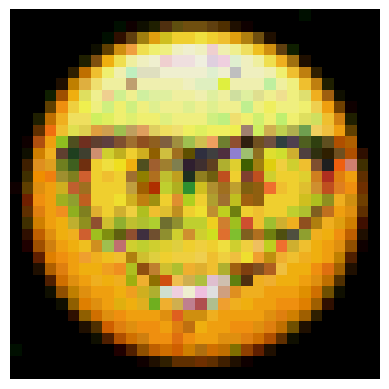

In [193]:
referece_test_image, _ = emoji_dataset[65]
referece_test_image = referece_test_image.unsqueeze(0).to(device)

# 41 46 63 71 83 66

with torch.no_grad():
    test_image = model(referece_test_image)
    print('shape: ', test_image.shape)
    # print(test_image.shape)
    flat1 = test_image.reshape(-1, num_classes)
    flat2 = referece_test_image.reshape(-1).long()
    l = loss(flat1, flat2)

    # print(F.softmax(flat1[29], dim=0))
    # print(flat2)
    print(l)
    
    generated_image = sample_from_pixelcnn(test_image)
    show_tensor_image(generated_image[0])


## Testing the model

This is a program sampling images from scratch using the trained model, performing a new forward pass for each new pixel and adding it to the image, recursively.

Obviously, autoregression models are extremely inefficient when generating a new images from scratch.

The outputs are not the best, but we can see that the model has learned some basic structures of the emojis, the shape of the face, eyes and mouth, etc.

Feel free to play around with the temperature term which is currently 0.6 in the model.

**Note** - The reason why many generated emojis have a straight bottom right part of the face is most likely due to the blind spot of our Masked Convolutional layers. This could have been solved by seperating the process into the vertical and horizontal stacks as stated in this [tutorial](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial12/Autoregressive_Image_Modeling.html).

In [173]:
def generate_image(model, image_size=16, num_classes=256, temperature=1):
    # Start with a blank image (batch_size=1, 3 channels for RGB, height, width)
    generated_image = torch.zeros(1, 3, image_size, image_size).to(device)
    
    # Iterate over every pixel, row by row, column by column
    for i in range(image_size):
        # print('i: ', i)
        for j in range(image_size):
            # Forward pass through the model to predict the distribution for the current pixel
            with torch.no_grad():  # No need to compute gradients
                if i > 0 or j > 0 or True: output = model(generated_image)
                else: 
                    output = torch.rand(1, 3, image_size, image_size, num_classes).to(device)
                    # print(output.shape)
            
            output = output / temperature
            
            pixel_outputs_r = sample_one_pixel(output[0][0][i][j])
            pixel_outputs_g = sample_one_pixel(output[0][1][i][j])
            pixel_outputs_b = sample_one_pixel(output[0][2][i][j])
            # print(pixel_outputs_r, pixel_outputs_g, pixel_outputs_b)

            # print(pixel_outputs)
            
            # Assign the sampled pixel values to the corresponding pixel in the image
            generated_image[0, 0, i, j] = pixel_outputs_r  # Normalize between 0 and 1
            generated_image[0, 1, i, j] = pixel_outputs_g
            generated_image[0, 2, i, j] = pixel_outputs_b

    return generated_image

Higer temperature produces more diverse images, lower temperature produces more stable outputs.

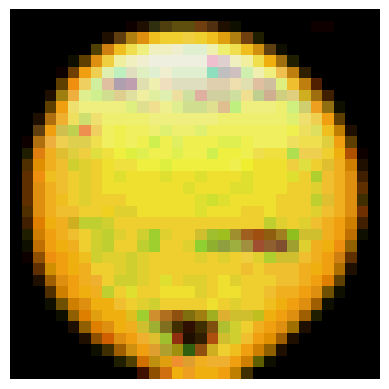

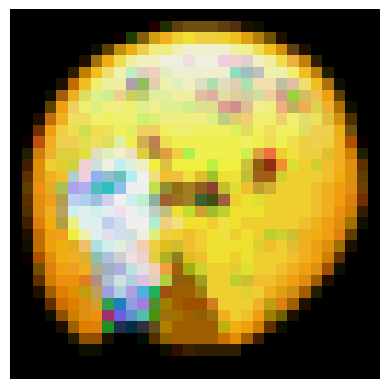

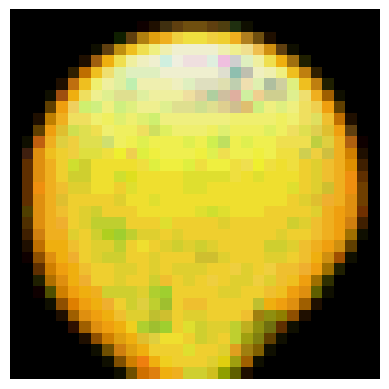

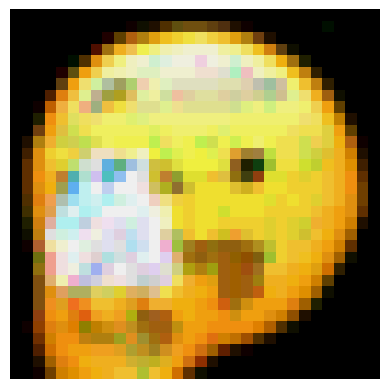

In [177]:
for i in range(4):
    generated_image = generate_image(model, image_size=image_size, num_classes=num_classes, temperature=0.6)
    generated_image = generated_image.cpu()
    show_tensor_image(generated_image[0])

# Conclusion

Autoregression is a relatively simple approach to generative tasks as image creation, but might not be the most suitable. Generating a high resolution image with this model would require height*width  number of iterations (for a 1080p image that would be close to 1 million) in comparison with some more sophisticated models like diffusion models which need only around 100-1000 steps.

The dataset used for training was very small, especially after I have narrowed it down only on face-like emojis, but we can still see that the resulting images resemble real emojis at least a little bit.

With a larger dataset (maybe including other operating system emojis), with longer training and maybe a little playing around with the parameters and the model hidden layer structure, we could have achieved better results. But this is more than enough to demonstrate the functionality of autoregressive models like PixelCNN.